In [10]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
figsize = (6, 4)

In [75]:
# Analysis of test_levels
def read_tests_level_time(fn):
    df = []
    h = 0
    a = 0
    level = 0
    numTasks = 0
    with open(fn, 'r', encoding='utf-8') as f:
        for line in f.readlines():        
            if 'Running with' in line:
                data = {'level':[], 'time(s)':[], 'proc':[],'cost_local':[], 'cost_global':[], 'tasks':[], 'h':[], 'a':[]}
            elif 'Level:' in line:
                level = int(line.split(':')[-1].strip())
            elif 'Max hours:' in line:
                h = int(line.split(':')[-1].strip())
            elif 'Max actuations:' in line:
                a = int(line.split(':')[-1].strip())
            elif 'tasks' in line:
                numTasks = int(line.split(' ')[1])
            elif 'Proc ' in line:
                tokens = line.split(' ')
                proc = int(tokens[1])
                time = float(tokens[4])
                cost_local = tokens[-2].split('=')[-1].replace(',', '')
                cost_global = tokens[-1].split('=')[-1].replace(')', '')
                # add data row
                data['level'].append(level)
                data['time(s)'].append(time)            
                data['proc'].append(proc)
                data['cost_local'].append(float(cost_local))
                data['cost_global'].append(float(cost_global))
                data['tasks'].append(numTasks)                
                data['h'].append(h)
                data['a'].append(a)
            if '-------' in line:
                df.append(pd.DataFrame(data))
    # merge all dataframes
    df = pd.concat(df)
    # get keep only the min and max time for each level
    df = df.groupby('level').agg({'time(s)': ['min', 'max'], 'tasks': 'max', 'h': 'max', 'a': 'max', 'tasks': 'max'}).reset_index()
    df.columns = ['level', 'minTime(s)', 'maxTime(s)', 'tasks', 'h', 'a']
    return df

def read_tests_level_memory(fn):
    df = []
    data = {'level':[], 'memory(GB)':[]}
    with open(fn, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if 'for l = ' in line:
                level = int(line.split('=')[-1].strip().replace(':', ''))
            elif '2025-' in line:
                memory = float(line.split(' ')[-1].replace('Gi', ''))
                data['level'].append(level)
                data['memory(GB)'].append(memory)

    df = pd.DataFrame(data)
    # Keep only the min and max memory for each level
    df = df.groupby('level').agg({'memory(GB)': ['min', 'max']}).reset_index()
    df.columns = ['level', 'minMemory(GB)', 'maxMemory(GB)']
    # The minimum memory is the initial memory (without running the solver)
    df['peakMemory(GB)'] = df['maxMemory(GB)'] - df['minMemory(GB)']
    return df

df_levels_time = read_tests_level_time("build/tests_level/tests_level_time.txt")
df_levels_memory = read_tests_level_memory("build/tests_level/tests_level_memory.txt")
df_levels = pd.merge(df_levels_time, df_levels_memory, on='level')
df_levels

,level,minTime(s),maxTime(s),tasks,h,a,minMemory(GB),maxMemory(GB),peakMemory(GB)
0,3,0.116,108.433,64,24,2,1.4,1.6,0.2
1,4,7.236,81.271,256,24,2,1.4,1.6,0.2
2,5,12.270,54.187,1024,24,2,1.4,1.6,0.2
3,6,14.046,53.932,4096,24,2,1.5,1.8,0.3
4,7,17.160,39.284,16384,24,2,1.5,2.4,0.9
5,8,21.986,36.115,65536,24,2,1.5,4.7,3.2
6,9,22.635,35.570,262144,24,2,1.5,11.0,9.5
7,10,39.237,48.629,1048576,24,2,1.5,31.0,29.5


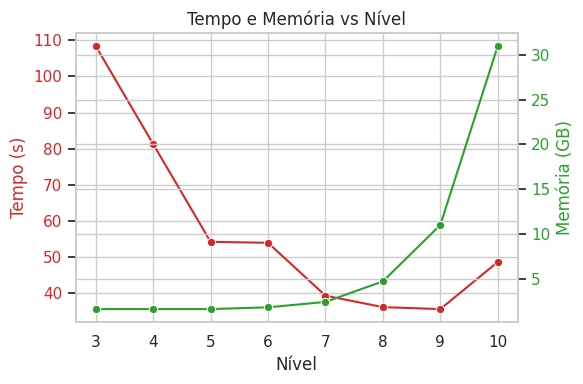

In [110]:
# Assuming 'figsize' and 'df_levels' are already defined
fig, ax1 = plt.subplots(figsize=figsize)

# Plotting Tempo (Time) on the first y-axis
color1 = 'tab:red'
sns.lineplot(
    data=df_levels, 
    x='level', 
    y='maxTime(s)', 
    marker='o', 
    color=color1, 
    ax=ax1
)
ax1.set_xlabel('Nível')
ax1.set_ylabel('Tempo (s)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Creating a second y-axis for Memória (Memory)
ax2 = ax1.twinx()  # Share the same x-axis

color2 = 'tab:green'
sns.lineplot(
    data=df_levels, 
    x='level', 
    y='maxMemory(GB)', 
    marker='o', 
    color=color2, 
    ax=ax2
)
ax2.set_ylabel('Memória (GB)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Adding a title
plt.title('Tempo e Memória vs Nível')

# Manually creating a combined legend
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles_ax1 + handles_ax2
labels = labels_ax1 + labels_ax2

# Ensuring layout is tight so labels and titles are well-spaced
fig.tight_layout()

# Display the plot
plt.show()



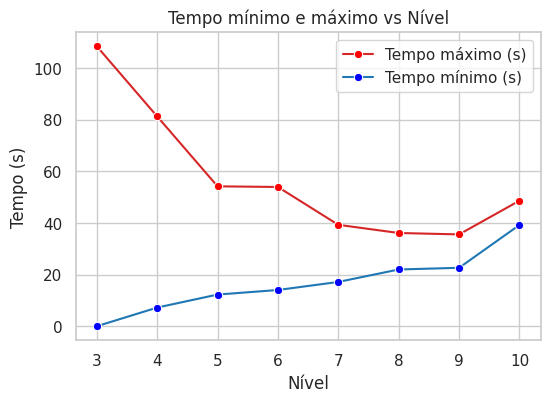

In [35]:
# Create a plot to illustrate the unbalancing measure
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=df_levels, x='level', y='maxTime(s)', marker='o', label='Tempo máximo (s)', color='tab:red', markerfacecolor='red')
sns.lineplot(data=df_levels, x='level', y='minTime(s)', marker='o', label='Tempo mínimo (s)', color='tab:blue', markerfacecolor='blue')
plt.title('Tempo mínimo e máximo vs Nível')
plt.xlabel('Nível')
plt.ylabel('Tempo (s)')
plt.legend()
plt.show()

In [81]:
def read_tests_scaling(fn):
    df = []
    h = 0
    a = 0
    numTasks = 0
    with open(fn, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if 'Running with' in line:
                data = {'level':[], 'time(s)':[], 'proc':[],'cost_local':[], 'cost_global':[], 'tasks':[], 'h':[], 'a':[], 'nproc':[]}
                nproc = int(line.split(' ')[-1])
            elif 'Level:' in line:
                level = int(line.split(':')[-1].strip())
            elif 'Max hours:' in line:
                h = int(line.split(':')[-1].strip())
            elif 'Max actuations:' in line:
                a = int(line.split(':')[-1].strip())
            elif 'tasks' in line:
                numTasks = int(line.split(' ')[1])
            elif 'Proc ' in line:
                tokens = line.split(' ')
                proc = int(tokens[1])
                time = float(tokens[4])
                cost_local = tokens[-2].split('=')[-1].replace(',', '')
                cost_global = tokens[-1].split('=')[-1].replace(')', '')
                # add data row
                data['level'].append(level)
                data['time(s)'].append(time)            
                data['proc'].append(proc)
                data['cost_local'].append(float(cost_local))
                data['cost_global'].append(float(cost_global))
                data['tasks'].append(numTasks)                
                data['h'].append(h)
                data['a'].append(a)
                data['nproc'].append(nproc)
            if '-------' in line:
                df.append(pd.DataFrame(data))
    # merge all dataframes
    df = pd.concat(df)
    # get keep only the min and max time for each processor
    df = df.groupby('nproc').agg({'time(s)': ['min', 'max'], 'tasks': 'max', 'cost_local': 'min', 'cost_global': 'max', 'level': 'max', 'h': 'max', 'a': 'max'}).reset_index()
    df.columns = ['nproc', 'minTime(s)', 'maxTime(s)', 'tasks', 'minCost(local)', 'maxCost(global)', 'level', 'h', 'a']
    return df

df_scaling = read_tests_scaling(os.path.join('build','tests_scaling','tests_scaling.txt'))
df_scaling

,nproc,minTime(s),maxTime(s),tasks,minCost(local),maxCost(global),level,h,a
0,1,278.147,278.147,262144,3586.26,3586.26,9,24,2
1,2,134.680,142.574,262144,3586.26,3586.26,9,24,2
2,3,94.045,104.007,262144,3586.26,3586.26,9,24,2
3,4,64.338,77.626,262144,3586.26,3586.26,9,24,2
4,5,55.115,61.831,262144,3586.26,3619.28,9,24,2
5,6,43.471,56.660,262144,3586.26,3636.86,9,24,2
6,7,38.246,49.281,262144,3586.26,3636.22,9,24,2
7,8,36.192,45.167,262144,3586.26,3627.91,9,24,2
8,9,32.822,42.003,262144,3586.26,3619.28,9,24,2
9,10,32.053,41.078,262144,3586.26,3637.04,9,24,2


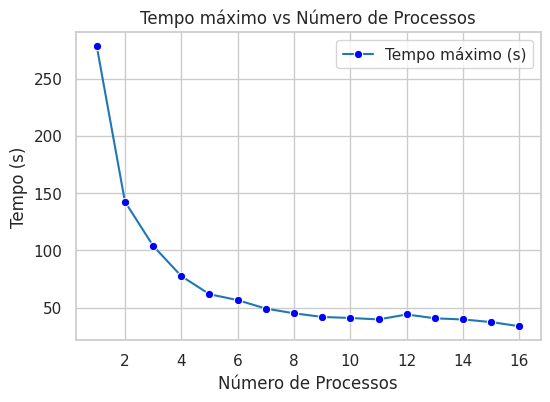

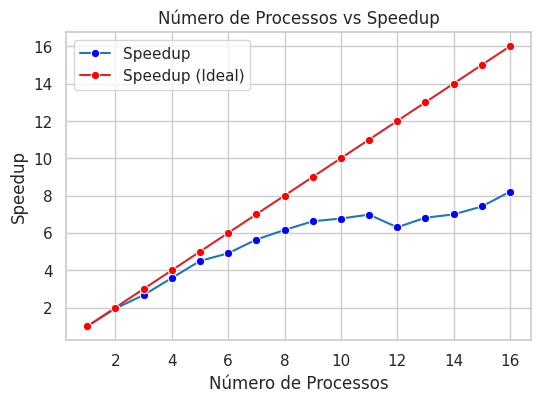

In [82]:
# Paralellism vs Time
fig = plt.figure(figsize=figsize)
sns.lineplot(data=df_scaling, x='nproc', y='maxTime(s)', marker='o', label='Tempo máximo (s)', color='tab:blue', markerfacecolor='blue')
plt.title('Tempo máximo vs Número de Processos')
plt.xlabel('Número de Processos')
plt.ylabel('Tempo (s)')
plt.show()

# Parallelism vs Speedup
timeNP1 = df_scaling[df_scaling['nproc'] == 1]['maxTime(s)'].values[0]
df_scaling['speedup'] = timeNP1 / df_scaling['maxTime(s)']
df_scaling['speedup (ideal)'] = df_scaling['nproc']
fig = plt.figure(figsize=figsize)
sns.lineplot(data=df_scaling, x='nproc', y='speedup', marker='o', label='Speedup', color='tab:blue', markerfacecolor='blue')
sns.lineplot(data=df_scaling, x='nproc', y='speedup (ideal)', marker='o', label='Speedup (Ideal)', color='tab:red', markerfacecolor='red')
plt.title('Número de Processos vs Speedup')
plt.xlabel('Número de Processos')
plt.ylabel('Speedup')
plt.show()

In [100]:
def read_stats(fn: str) -> pd.DataFrame:
    with open (fn, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    # drop line 0 it is artifact
    df = df.drop(0)
    return df

def read_best(fn: str) -> pd.DataFrame:
    with open (fn, 'r') as f:
        data = json.load(f)
    data['best_x'] = np.array(data['best_x']).reshape(-1, 3).tolist()    
    df = pd.DataFrame(data, columns=['best_y', 'best_x', 'best_cost'])
    df.rename(columns={'best_y': 'y', 'best_x': 'x', 'best_cost': 'cost'}, inplace=True)
    # drop line 0 it is artifact
    df = df.drop(0)
    return df

In [101]:
def read_results():
    wd = 'build/tests_results'
    prefixes = set([fn.replace('_best.json','').replace('_stats.json','') for fn in os.listdir(wd) if 'run_h_24_' in fn])
    df = []
    for prefix in sorted(prefixes):
        if '_prof.txt' in prefix:
            continue
        try:
            df_best = read_best(os.path.join(wd, prefix + '_best.json'))
            df_stats = read_stats(os.path.join(wd, prefix + '_stats.json'))
        except:
            print(f'Error reading {prefix}, skipping...')
            continue
        # merge best and stats
        df_local = pd.concat([df_best, df_stats], axis=1)
        # add rank
        rank = int(prefix.split('_r_')[1].split('_')[0])
        df_local['rank'] = rank
        # add actuations
        actuations = int(prefix.split('_a_')[1].split('_')[0])
        df_local['actuations'] = actuations
        # add prefix
        df_local['prefix'] = prefix        
        df.append(df_local)        
    # return merged dataframes
    return pd.concat(df)

df = read_results() 
df


,y,x,cost,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,duration,rank,actuations,prefix
1,1,"[1, 0, 0]",3914.398067,0,0,1,3,0,0,0,1.652105,0,1,run_h_24_a_01_l_01_n_01_r_00
2,1,"[1, 0, 0]",3914.398067,0,0,2,10,0,0,0,1.652105,0,1,run_h_24_a_01_l_01_n_01_r_00
3,1,"[1, 0, 0]",3914.398067,0,0,13,27,0,0,0,1.652105,0,1,run_h_24_a_01_l_01_n_01_r_00
4,1,"[1, 0, 0]",3914.398067,15,0,30,63,0,0,0,1.652105,0,1,run_h_24_a_01_l_01_n_01_r_00
5,1,"[1, 0, 0]",3914.398067,56,0,73,123,0,0,0,1.652105,0,1,run_h_24_a_01_l_01_n_01_r_00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0,"[0, 0, 0]",3624.651074,671097,1296684,612083,559288,1259,0,0,464.151244,15,3,run_h_24_a_03_l_09_n_16_r_15
21,0,"[0, 0, 0]",3624.651074,187999,521732,533651,13924,270,0,0,464.151244,15,3,run_h_24_a_03_l_09_n_16_r_15
22,1,"[1, 0, 0]",3624.651074,7653,9666,21479,2783,3,0,0,464.151244,15,3,run_h_24_a_03_l_09_n_16_r_15
23,1,"[1, 0, 0]",3624.651074,2452,2662,729,663,0,0,0,464.151244,15,3,run_h_24_a_03_l_09_n_16_r_15


In [102]:
def show_prunes(df_local: pd.DataFrame):
    columns = [c for c in df_local.columns if c not in ['y','x','cost','duration','actuations','prefix','rank']]
    df_prunes = df_local[columns].copy().reset_index()
    df_prunes['h'] = np.arange(len(df_prunes)) % 24 + 1
    df_agg = df_prunes.groupby('h').agg('sum').reset_index()
    df_agg.drop(columns=['index'], inplace=True)
    df_agg.rename({'NONE':'FEASIBLE'}, inplace=True)
    total = np.zeros(len(df_agg))
    for c in df_agg.columns:
        if c != 'h':
            total += df_agg[c]
    df_agg['TOTAL'] = total
    df_agg['TOTAL'] = df_agg['TOTAL'].astype(int)
    # organize columns
    columns = ['h','FEASIBLE'] + [c for c in df_agg.columns if c not in ['h','FEASIBLE','TOTAL']] + ['TOTAL']
    print('Prunes:')
    display(df_agg)

def show_best(prefix:str):
    df_local = df[df['prefix'].str.contains(prefix)]
    if len(df_local) == 0:
        print(f'No data for prefix: {prefix}')
        return
    best_cost = df_local['cost'].min()
    df_best = df_local[df_local['cost'] == best_cost]
    prefix = df_best['prefix'].values[0]
    duration = df_local['duration'].max()
    a = int(prefix.split('_a_')[1].split('_')[0])
    n = int(prefix.split('_n_')[1].split('_')[0])
    y = df_best['y'].tolist()
    y_str = ''.join([f'{v}' for v in y])    
    x = np.array(df_best['x'].tolist())
    x1_str = 'best x: ' + ''.join([f'{v}' for v in x[:,0]])
    x2_str = '        ' + ''.join([f'{v}' for v in x[:,1]])
    x3_str = '        ' + ''.join([f'{v}' for v in x[:,2]])
    print(f'max actuations: {a}, nprocs: {n}')
    print(f'best cost: ${best_cost:.2f}')
    print(f'duration : {duration:.2f} s')
    print(f'best y: {y_str}')    
    print(x1_str)
    print(x2_str)
    print(x3_str)
    print(f'prefix: {prefix}\n')    
    show_prunes(df_local)    

show_best('run_h_24_a_01_l_01_n_01')
show_best('run_h_24_a_02_l_09_n_16')
show_best('run_h_24_a_03_l_09_n_16')

max actuations: 1, nprocs: 1
best cost: $3914.40
duration : 1.65 s
best y: 111111111112112222000111
best x: 111111111111000000000111
        000000000001111111000000
        000000000000001111000000
prefix: run_h_24_a_01_l_01_n_01_r_00

Prunes:


,h,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,TOTAL
0,1,0,0,1,3,0,0,0,4
1,2,0,0,2,10,0,0,0,12
2,3,0,0,13,27,0,0,0,40
3,4,15,0,30,63,0,0,0,108
4,5,56,0,73,123,0,0,0,252
5,6,150,0,124,218,0,0,0,492
6,7,313,0,146,412,1,0,0,872
7,8,716,0,245,687,0,0,0,1648
8,9,1337,0,394,1016,1,0,0,2748
9,10,2141,0,432,1489,2,0,0,4064


max actuations: 2, nprocs: 16
best cost: $3618.59
duration : 35.14 s
best y: 122111111022212121000111
best x: 111000000011111000000111
        011111111000001110000000
        000000000011100011000000
prefix: run_h_24_a_02_l_09_n_16_r_10

Prunes:


,h,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,TOTAL
0,1,0,0,44087,146795,0,0,0,190882
1,2,0,0,25933,120862,0,0,0,146795
2,3,0,0,42905,77957,0,0,0,120862
3,4,0,0,23201,54756,0,0,0,77957
4,5,0,0,18876,35880,0,0,0,54756
5,6,0,0,12161,23719,0,0,0,35880
6,7,0,0,6182,17521,16,0,0,23719
7,8,0,0,4582,12935,4,0,0,17521
8,9,0,0,3286,9628,21,0,0,12935
9,10,8036,0,8206,22108,162,0,0,38512


max actuations: 3, nprocs: 16
best cost: $3575.53
duration : 552.99 s
best y: 122111110023302221000210
best x: 111000000011101111000000
        011111110001100000000100
        000000000011101110000110
prefix: run_h_24_a_03_l_09_n_16_r_00

Prunes:


,h,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,TOTAL
0,1,0,0,64762,195312,0,0,0,260074
1,2,0,0,32677,162635,0,0,0,195312
2,3,0,0,53066,109569,0,0,0,162635
3,4,0,0,33555,76014,0,0,0,109569
4,5,0,0,26114,49900,0,0,0,76014
5,6,0,0,17417,32483,0,0,0,49900
6,7,0,0,8571,23896,16,0,0,32483
7,8,0,0,5888,18004,4,0,0,23896
8,9,0,0,4321,13654,29,0,0,18004
9,10,1233,0,13217,39748,418,0,0,54616
